In [46]:
year=2019
month=10

In [38]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [71]:
conn=db.get_conn()
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000", con=conn)
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

def get_summary(data, career):
    
    salaries = data.monthly_salary.values
    headcounts = data.headcount.values
    head_count=np.sum(headcounts)
    salary_average=int(np.average(salaries, weights=headcounts))
    q = weighted.weighted_quantile(salaries,[0.025,0.5,0.975],headcounts)
    print(f"2019年{month}月全国招收{career}{head_count}人。2019年{month}月全国{career}平均工资{salary_average:.0f}元，工资中位数{q[1]:.0f}元，其中95%的人的工资介于{q[0]:.0f}元到{q[2]:.0f}元。\r\n")
    return head_count, salary_average, q[1]
    
headcount, mean, median=get_summary(data, '程序员')
conn.execute(f"delete from MonthlyStats where Month='{year}{month:02}'")
sql="insert into MonthlyStats(Month, Salary_Mean, Salary_Median, JD_Count, HeadCount)"
sql=sql+f" values('{year}{month:02}',{mean},{median},{data.shape[0]},{headcount})"
conn.execute(sql)


2019年10月全国招收程序员284579人。2019年10月全国程序员平均工资13337元，工资中位数12500元，其中95%的人的工资介于3750元到32500元。



In [92]:

join_counts=[conn.execute(f"select COUNT(1) from _{year}{month:02}").fetchall()[0][0]]
percents=[]
for i in range(1,month-6+1):
    sql=f"select COUNT(1) from _{year}{month:02} a join _{year}{month-i:02} b on a.job_id = b.job_id"
    #print(sql)
    count=conn.execute(sql).fetchall()[0][0]

    join_counts.append(count)
    subtract = join_counts[i-1]-join_counts[i]
    percents.append(subtract*1.0/join_counts[i])

percents.append(join_counts[-1]/join_counts[0])

In [93]:
join_counts

[92832, 78853, 65232, 54493, 48358]

In [94]:
percents

[0.17727924111955157,
 0.20880856021584498,
 0.19707118345475566,
 0.12686628892840895,
 0.520919510513616]

([<matplotlib.patches.Wedge at 0x1bd651b84a8>,
 [Text(0.9893173102753859, 0.4808859111987749, '1'),
  Text(0.14584966031858357, 1.0902879787399997, '2'),
  Text(-0.8636361523034963, 0.6812727768188102, '3'),
  Text(-1.086151464433701, -0.17399711580519653, '4'),
  Text(0.2628788116627787, -1.0681267389119915, '5+')])

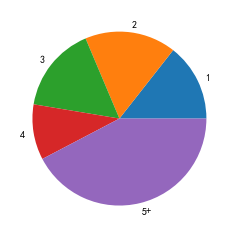

In [102]:
plt.pie(percents, labels=['1','2','3','4','5+'])

In [67]:
month

10

In [68]:
data.shape[0]

87620

In [ ]:
conn.close()

In [8]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

data_format={"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}"}



In [9]:
data_career=get_sub_stats_by_col(data,'career')
data_career.style.format(data_format)

,career,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
2,系统架构师,22372,5400,20000,50000,8941,3.14%
1,算法工程师,18650,5250,17500,45000,24366,8.56%
0,一般程序员,12502,3750,11500,30000,250845,88.15%
3,爬虫工程师,11808,2500,11500,27500,391,0.14%
4,生物信息工程师,10500,7000,9625,15000,36,0.01%


# 程序员工资

In [10]:
data_city=get_sub_stats_by_col(data,'province')
#data_city.city=data_city.city.map(translate_dict)
data_city.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,16709,3750,14583,45000,25000,8.78%
上海,16544,5250,15000,37500,44305,15.57%
广东,14628,4750,12500,35000,74598,26.21%
浙江,13687,3500,12500,30000,17761,6.24%
四川,12120,3500,11500,29072,12053,4.24%
江苏,11839,3750,11500,25000,29563,10.39%
湖北,11430,3750,10500,25000,15402,5.41%
陕西,11163,4500,10500,22500,7219,2.54%
湖南,11115,3892,10500,25000,6510,2.29%
天津,10485,4025,9500,22500,2290,0.80%


In [11]:
def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print(f"2019年{month}月{row[0]}招收{career}{row[5]}人。2019年{month}月{row[0]}{career}平均工资{row[1]:.0f}元，工资中位数{row[3]:.0f}元，其中95%的人的工资介于{row[2]:.0f}元到{row[4]:.0f}元。\r\n")


In [12]:
describe(data_city,'程序员')

2019年10月北京招收程序员25000人。2019年10月北京程序员平均工资16709元，工资中位数14583元，其中95%的人的工资介于3750元到45000元。

2019年10月上海招收程序员44305人。2019年10月上海程序员平均工资16544元，工资中位数15000元，其中95%的人的工资介于5250元到37500元。

2019年10月广东招收程序员74598人。2019年10月广东程序员平均工资14628元，工资中位数12500元，其中95%的人的工资介于4750元到35000元。

2019年10月浙江招收程序员17761人。2019年10月浙江程序员平均工资13687元，工资中位数12500元，其中95%的人的工资介于3500元到30000元。

2019年10月四川招收程序员12053人。2019年10月四川程序员平均工资12120元，工资中位数11500元，其中95%的人的工资介于3500元到29072元。

2019年10月江苏招收程序员29563人。2019年10月江苏程序员平均工资11839元，工资中位数11500元，其中95%的人的工资介于3750元到25000元。

2019年10月湖北招收程序员15402人。2019年10月湖北程序员平均工资11430元，工资中位数10500元，其中95%的人的工资介于3750元到25000元。

2019年10月陕西招收程序员7219人。2019年10月陕西程序员平均工资11163元，工资中位数10500元，其中95%的人的工资介于4500元到22500元。

2019年10月湖南招收程序员6510人。2019年10月湖南程序员平均工资11115元，工资中位数10500元，其中95%的人的工资介于3892元到25000元。

2019年10月天津招收程序员2290人。2019年10月天津程序员平均工资10485元，工资中位数9500元，其中95%的人的工资介于4025元到22500元。

2019年10月重庆招收程序员4017人。2019年10月重庆程序员平均工资10406元，工资中位数9500元，其中95%的人的工资介于4000元到25000元。

2019年10月福建招收程序员5566人。2019年10月福建程序员平均工资10401元，工资中位数10000元，其中95%的人的工资介于37

In [13]:
data_location = pd.read_csv('../../data/provincial_capital_locations.csv', encoding='utf-8')
data_location=data_location.set_index('province')

In [14]:
from mpl_toolkits.basemap import Basemap

In [15]:
def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city.salary_mean.min()
    salary_max=data_city.salary_mean.max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        province=row[0]
        
        longitude = data_location.loc[province,'longitude']
        latitude = data_location.loc[province,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if province == '浙江':
            #x=x-400000
            y=y-100000

        elif province=='安徽':
            x=x-300000
            y=y+10000
        elif province=='江苏':
            x=x-150000
        elif province=='天津':
            y=y-50000
        elif province=='上海':
            x=x+50000
        elif province=='湖北':
            y=y-50000

        ax.text(x, y, "{}{:.0f}k".format(province, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(province, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(province, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(province, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


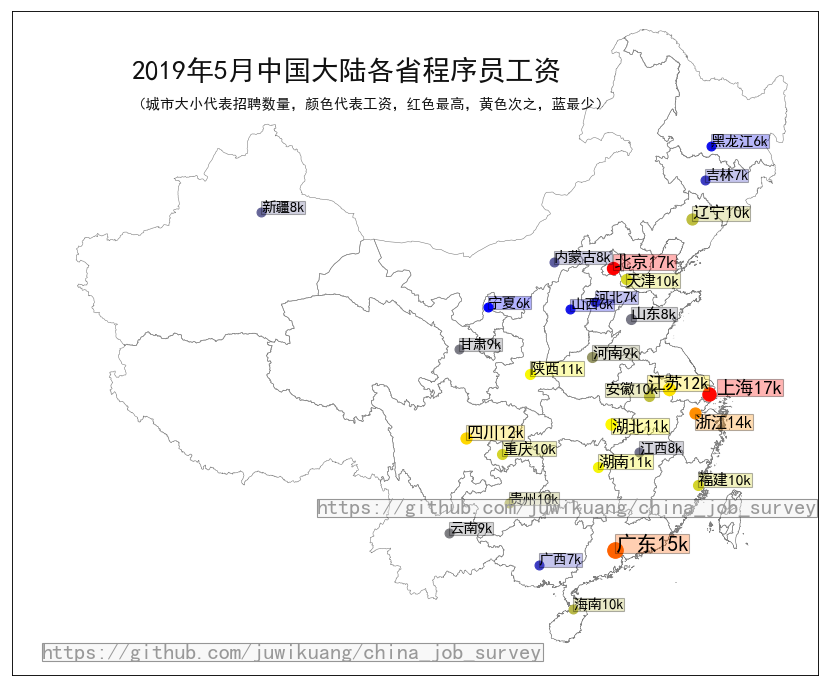

In [16]:
draw_map(data_city,2000,'2019年5月中国大陆各省程序员工资')

# 算法工程师

In [17]:
get_summary(data[data.career=='算法工程师'], '算法工程师')

2019年10月全国招收算法工程师24366人。2019年10月全国算法工程师平均工资18650元，工资中位数17500元，其中95%的人的工资介于5250元到45000元。



In [18]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'province')

data_city_algorithm.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,22933,5250,21500,55000,2930,12.02%
上海,22384,6500,20833,45833,4635,19.02%
海南,21364,12562,15000,35000,22,0.09%
广东,19318,5750,17500,45000,6780,27.83%
浙江,18806,3750,17500,45000,1648,6.76%
江苏,16215,5000,15000,32500,2759,11.32%
四川,15278,5250,14000,31250,1019,4.18%
湖北,15115,3802,15000,27500,1143,4.69%
安徽,14788,5673,12500,36446,359,1.47%
湖南,14561,7000,12500,27425,466,1.91%


In [19]:
describe(data_city_algorithm,'算法工程师')

2019年10月北京招收算法工程师2930人。2019年10月北京算法工程师平均工资22933元，工资中位数21500元，其中95%的人的工资介于5250元到55000元。

2019年10月上海招收算法工程师4635人。2019年10月上海算法工程师平均工资22384元，工资中位数20833元，其中95%的人的工资介于6500元到45833元。

2019年10月海南招收算法工程师22人。2019年10月海南算法工程师平均工资21364元，工资中位数15000元，其中95%的人的工资介于12562元到35000元。

2019年10月广东招收算法工程师6780人。2019年10月广东算法工程师平均工资19318元，工资中位数17500元，其中95%的人的工资介于5750元到45000元。

2019年10月浙江招收算法工程师1648人。2019年10月浙江算法工程师平均工资18806元，工资中位数17500元，其中95%的人的工资介于3750元到45000元。

2019年10月江苏招收算法工程师2759人。2019年10月江苏算法工程师平均工资16215元，工资中位数15000元，其中95%的人的工资介于5000元到32500元。

2019年10月四川招收算法工程师1019人。2019年10月四川算法工程师平均工资15278元，工资中位数14000元，其中95%的人的工资介于5250元到31250元。

2019年10月湖北招收算法工程师1143人。2019年10月湖北算法工程师平均工资15115元，工资中位数15000元，其中95%的人的工资介于3802元到27500元。

2019年10月安徽招收算法工程师359人。2019年10月安徽算法工程师平均工资14788元，工资中位数12500元，其中95%的人的工资介于5673元到36446元。

2019年10月湖南招收算法工程师466人。2019年10月湖南算法工程师平均工资14561元，工资中位数12500元，其中95%的人的工资介于7000元到27425元。

2019年10月陕西招收算法工程师751人。2019年10月陕西算法工程师平均工资14259元，工资中位数12932元，其中95%的人的工资介于5111元到30000元。

2019年10月福建招收算法工程师322人。2019年10月福建算法工程

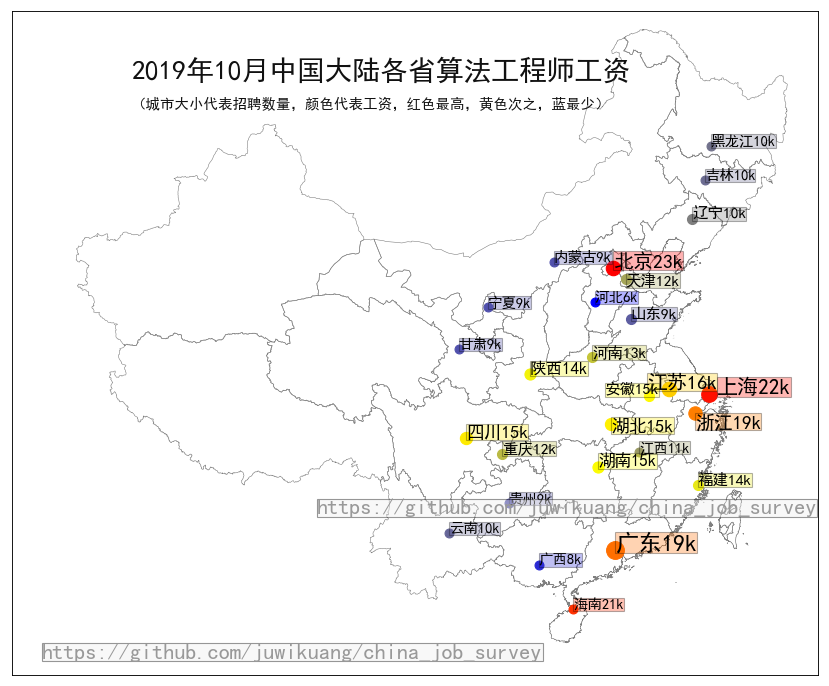

In [20]:
draw_map(data_city_algorithm,100,f'2019年{month}月中国大陆各省算法工程师工资')

# 系统架构师

In [21]:
get_summary(data[data.career=='系统架构师'], '系统架构师')

2019年10月全国招收系统架构师8941人。2019年10月全国系统架构师平均工资22372元，工资中位数20000元，其中95%的人的工资介于5400元到50000元。



In [22]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'province')

data_city_architect.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,31682,8400,30000,60000,1088,12.17%
河北,28636,12500,15000,75000,11,0.12%
上海,24497,7000,22500,50000,1865,20.86%
广东,22999,5250,22500,46708,2630,29.42%
浙江,22681,6080,22500,45000,545,6.10%
四川,19201,6775,17500,45000,315,3.52%
海南,19071,10500,19071,22500,7,0.08%
江苏,18125,6000,17500,39000,860,9.62%
湖北,17825,5728,17500,35000,371,4.15%
陕西,17152,6222,17500,33600,212,2.37%


In [23]:
describe(data_city_architect,'系统架构师')

2019年10月北京招收系统架构师1088人。2019年10月北京系统架构师平均工资31682元，工资中位数30000元，其中95%的人的工资介于8400元到60000元。

2019年10月河北招收系统架构师11人。2019年10月河北系统架构师平均工资28636元，工资中位数15000元，其中95%的人的工资介于12500元到75000元。

2019年10月上海招收系统架构师1865人。2019年10月上海系统架构师平均工资24497元，工资中位数22500元，其中95%的人的工资介于7000元到50000元。

2019年10月广东招收系统架构师2630人。2019年10月广东系统架构师平均工资22999元，工资中位数22500元，其中95%的人的工资介于5250元到46708元。

2019年10月浙江招收系统架构师545人。2019年10月浙江系统架构师平均工资22681元，工资中位数22500元，其中95%的人的工资介于6080元到45000元。

2019年10月四川招收系统架构师315人。2019年10月四川系统架构师平均工资19201元，工资中位数17500元，其中95%的人的工资介于6775元到45000元。

2019年10月海南招收系统架构师7人。2019年10月海南系统架构师平均工资19071元，工资中位数19071元，其中95%的人的工资介于10500元到22500元。

2019年10月江苏招收系统架构师860人。2019年10月江苏系统架构师平均工资18125元，工资中位数17500元，其中95%的人的工资介于6000元到39000元。

2019年10月湖北招收系统架构师371人。2019年10月湖北系统架构师平均工资17825元，工资中位数17500元，其中95%的人的工资介于5728元到35000元。

2019年10月陕西招收系统架构师212人。2019年10月陕西系统架构师平均工资17152元，工资中位数17500元，其中95%的人的工资介于6222元到33600元。

2019年10月天津招收系统架构师19人。2019年10月天津系统架构师平均工资16947元，工资中位数16667元，其中95%的人的工资介于5000元到27500元。

2019年10月河南招收系统架构师74人。2019年10月河南系统架构师平均工资16

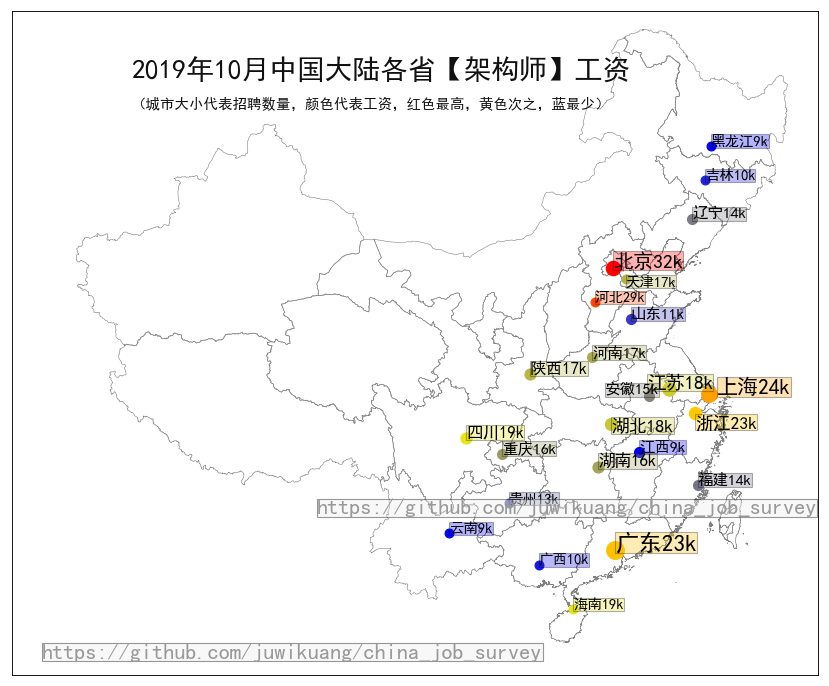

In [24]:
draw_map(data_city_architect,40,f'2019年{month}月中国大陆各省【架构师】工资')

# 生物信息工程师

In [25]:
get_summary(data[data.career=='生物信息工程师'], '生物信息工程师')

2019年10月全国招收生物信息工程师36人。2019年10月全国生物信息工程师平均工资10500元，工资中位数9625元，其中95%的人的工资介于7000元到15000元。



In [26]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'province')
#data_bio.city=data_bio.city.map(translate_dict)
data_bio.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,14286,12500,14167,15000,7,19.44%
浙江,12000,11500,12000,12500,2,5.56%
广东,9885,7000,8800,14000,13,36.11%
江苏,9875,9000,9875,12500,4,11.11%
上海,9800,8000,9800,12500,5,13.89%
湖北,9000,9000,9000,9000,1,2.78%
江西,7000,7000,7000,7000,1,2.78%
广西,7000,7000,7000,7000,3,8.33%


In [27]:
describe(data_bio,'生物信息工程师')

2019年10月北京招收生物信息工程师7人。2019年10月北京生物信息工程师平均工资14286元，工资中位数14167元，其中95%的人的工资介于12500元到15000元。

2019年10月浙江招收生物信息工程师2人。2019年10月浙江生物信息工程师平均工资12000元，工资中位数12000元，其中95%的人的工资介于11500元到12500元。

2019年10月广东招收生物信息工程师13人。2019年10月广东生物信息工程师平均工资9885元，工资中位数8800元，其中95%的人的工资介于7000元到14000元。

2019年10月江苏招收生物信息工程师4人。2019年10月江苏生物信息工程师平均工资9875元，工资中位数9875元，其中95%的人的工资介于9000元到12500元。

2019年10月上海招收生物信息工程师5人。2019年10月上海生物信息工程师平均工资9800元，工资中位数9800元，其中95%的人的工资介于8000元到12500元。

2019年10月湖北招收生物信息工程师1人。2019年10月湖北生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年10月江西招收生物信息工程师1人。2019年10月江西生物信息工程师平均工资7000元，工资中位数7000元，其中95%的人的工资介于7000元到7000元。

2019年10月广西招收生物信息工程师3人。2019年10月广西生物信息工程师平均工资7000元，工资中位数7000元，其中95%的人的工资介于7000元到7000元。



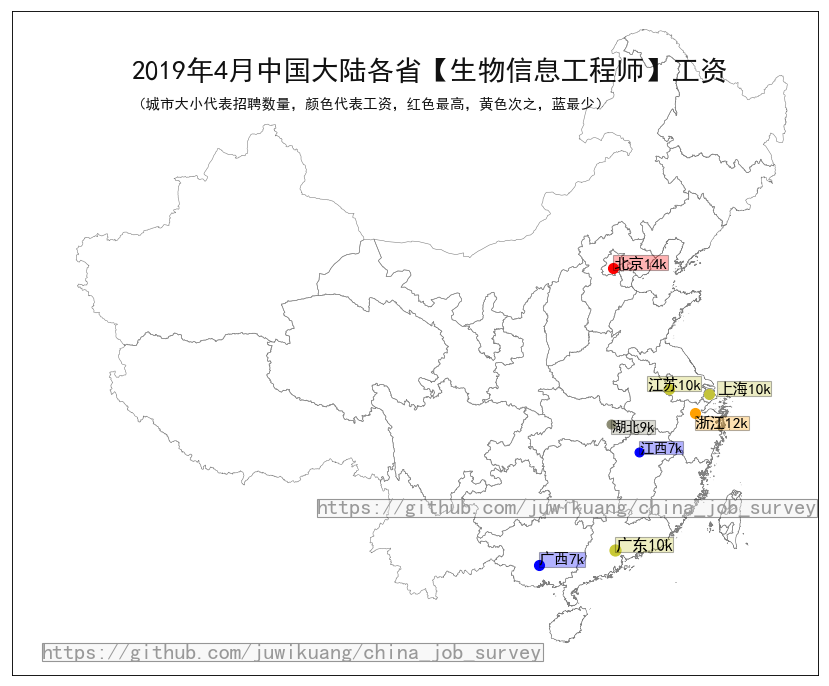

In [28]:
draw_map(data_bio,2,'2019年4月中国大陆各省【生物信息工程师】工资')

# 爬虫工程师

In [29]:
get_summary(data[data.career=='爬虫工程师'], '爬虫工程师')

2019年10月全国招收爬虫工程师391人。2019年10月全国爬虫工程师平均工资11808元，工资中位数11500元，其中95%的人的工资介于2500元到27500元。



In [30]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'province')


data_spider=data_spider[data_spider.head_count>10]
data_spider.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
江苏,15188,11567,14000,20000,24,6.14%
上海,14061,5046,12500,28812,106,27.11%
北京,13840,1750,12500,33438,25,6.39%
湖北,12031,7000,12000,20000,16,4.09%
广东,11639,4012,10643,35937,115,29.41%
浙江,11250,9000,11500,13000,16,4.09%
湖南,8854,7000,8833,11500,24,6.14%
四川,6490,2250,5650,14000,24,6.14%
河北,6250,6250,6250,6250,16,4.09%


In [31]:
describe(data_spider, '爬虫工程师')

2019年10月江苏招收爬虫工程师24人。2019年10月江苏爬虫工程师平均工资15188元，工资中位数14000元，其中95%的人的工资介于11567元到20000元。

2019年10月上海招收爬虫工程师106人。2019年10月上海爬虫工程师平均工资14061元，工资中位数12500元，其中95%的人的工资介于5046元到28812元。

2019年10月北京招收爬虫工程师25人。2019年10月北京爬虫工程师平均工资13840元，工资中位数12500元，其中95%的人的工资介于1750元到33438元。

2019年10月湖北招收爬虫工程师16人。2019年10月湖北爬虫工程师平均工资12031元，工资中位数12000元，其中95%的人的工资介于7000元到20000元。

2019年10月广东招收爬虫工程师115人。2019年10月广东爬虫工程师平均工资11639元，工资中位数10643元，其中95%的人的工资介于4012元到35937元。

2019年10月浙江招收爬虫工程师16人。2019年10月浙江爬虫工程师平均工资11250元，工资中位数11500元，其中95%的人的工资介于9000元到13000元。

2019年10月湖南招收爬虫工程师24人。2019年10月湖南爬虫工程师平均工资8854元，工资中位数8833元，其中95%的人的工资介于7000元到11500元。

2019年10月四川招收爬虫工程师24人。2019年10月四川爬虫工程师平均工资6490元，工资中位数5650元，其中95%的人的工资介于2250元到14000元。

2019年10月河北招收爬虫工程师16人。2019年10月河北爬虫工程师平均工资6250元，工资中位数6250元，其中95%的人的工资介于6250元到6250元。



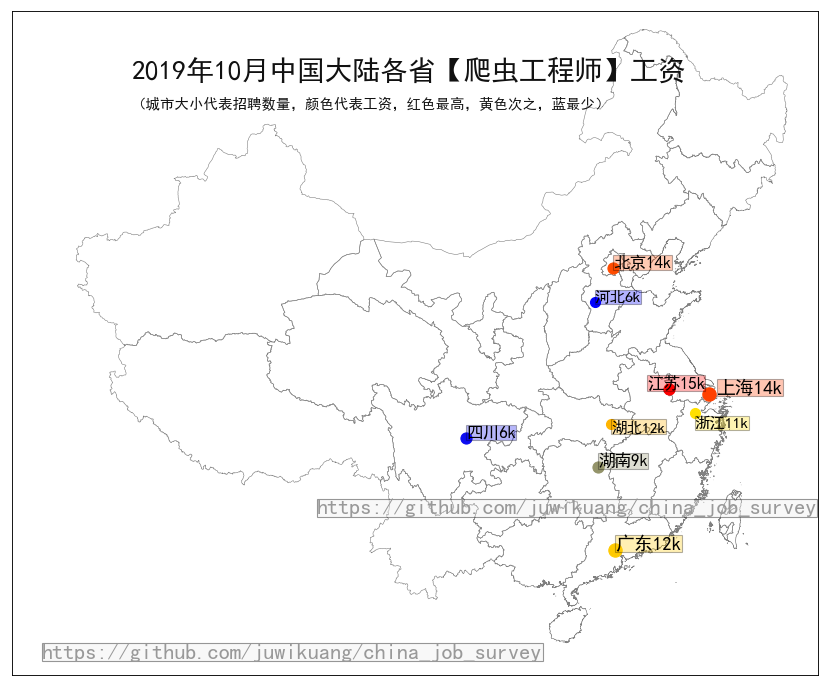

In [32]:
draw_map(data_spider,5,f'2019年{month}月中国大陆各省【爬虫工程师】工资')

# Java程序员

In [33]:
get_summary(data[data.pl_java==1], 'Java程序员')

2019年10月全国招收Java程序员130436人。2019年10月全国Java程序员平均工资13259元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。



In [34]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'province')
data_java.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
上海,16697,5500,15000,35000,19216,14.73%
北京,15541,3750,13000,37500,12072,9.26%
广东,14879,5000,12500,35000,33619,25.77%
浙江,13927,3000,12500,30000,8469,6.49%
江苏,11705,3750,11500,24000,13404,10.28%
四川,11602,2500,11000,25000,5016,3.85%
湖北,11206,5000,10416,25000,6179,4.74%
陕西,11033,4500,10500,22500,3257,2.50%
湖南,10863,3880,10500,22500,2994,2.30%
天津,10610,3750,10000,22500,1159,0.89%


In [35]:
describe(data_java, 'Java程序员')

2019年10月上海招收Java程序员19216人。2019年10月上海Java程序员平均工资16697元，工资中位数15000元，其中95%的人的工资介于5500元到35000元。

2019年10月北京招收Java程序员12072人。2019年10月北京Java程序员平均工资15541元，工资中位数13000元，其中95%的人的工资介于3750元到37500元。

2019年10月广东招收Java程序员33619人。2019年10月广东Java程序员平均工资14879元，工资中位数12500元，其中95%的人的工资介于5000元到35000元。

2019年10月浙江招收Java程序员8469人。2019年10月浙江Java程序员平均工资13927元，工资中位数12500元，其中95%的人的工资介于3000元到30000元。

2019年10月江苏招收Java程序员13404人。2019年10月江苏Java程序员平均工资11705元，工资中位数11500元，其中95%的人的工资介于3750元到24000元。

2019年10月四川招收Java程序员5016人。2019年10月四川Java程序员平均工资11602元，工资中位数11000元，其中95%的人的工资介于2500元到25000元。

2019年10月湖北招收Java程序员6179人。2019年10月湖北Java程序员平均工资11206元，工资中位数10416元，其中95%的人的工资介于5000元到25000元。

2019年10月陕西招收Java程序员3257人。2019年10月陕西Java程序员平均工资11033元，工资中位数10500元，其中95%的人的工资介于4500元到22500元。

2019年10月湖南招收Java程序员2994人。2019年10月湖南Java程序员平均工资10863元，工资中位数10500元，其中95%的人的工资介于3880元到22500元。

2019年10月天津招收Java程序员1159人。2019年10月天津Java程序员平均工资10610元，工资中位数10000元，其中95%的人的工资介于3750元到22500元。

2019年10月贵州招收Java程序员441人。2019年10月贵州Java程序员平均工资10609元，工资中位数9500元，其中95%的人的工资介于5

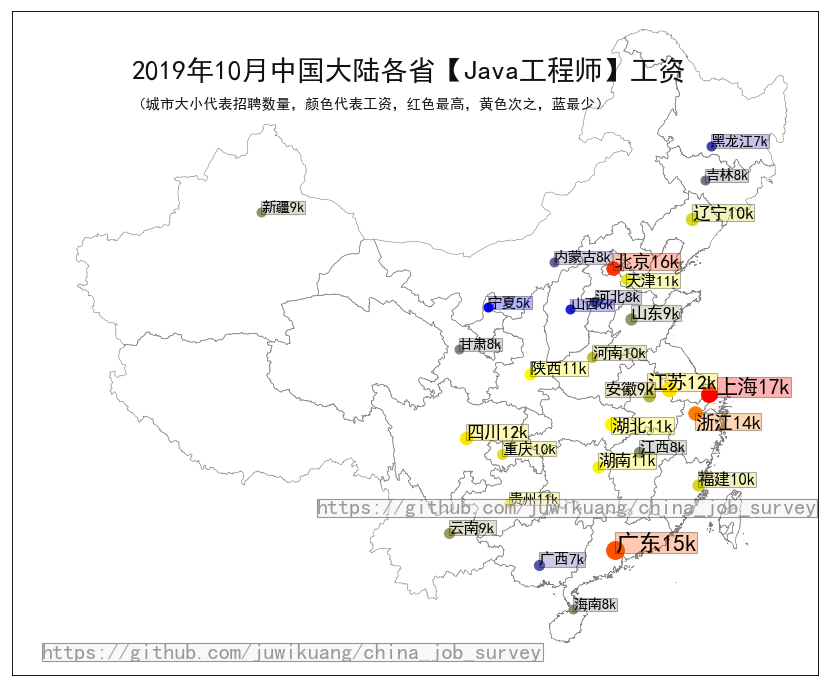

In [36]:
draw_map(data_java, 500, f'2019年{month}月中国大陆各省【Java工程师】工资')

# Python程序员

In [37]:
get_summary(data[data.pl_python==1], 'Python程序员')

2019年10月全国招收Python程序员29870人。2019年10月全国Python程序员平均工资17444元，工资中位数15000元，其中95%的人的工资介于4000元到40000元。



In [38]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'province')
data_python.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,21168,3750,20000,45000,3951,13.23%
上海,20741,6280,18750,45833,6196,20.74%
广东,18748,5250,17500,40000,7430,24.87%
海南,16076,6500,15000,35000,46,0.15%
浙江,15928,3750,14583,37500,1958,6.56%
四川,15578,4500,14000,34783,1399,4.68%
山西,15000,15000,15000,15000,5,0.02%
江苏,14775,4145,13000,30000,2855,9.56%
湖北,14201,4505,12500,30000,1343,4.50%
重庆,13361,3750,12500,32650,334,1.12%


In [39]:
describe(data_python, 'Python程序员')

2019年10月北京招收Python程序员3951人。2019年10月北京Python程序员平均工资21168元，工资中位数20000元，其中95%的人的工资介于3750元到45000元。

2019年10月上海招收Python程序员6196人。2019年10月上海Python程序员平均工资20741元，工资中位数18750元，其中95%的人的工资介于6280元到45833元。

2019年10月广东招收Python程序员7430人。2019年10月广东Python程序员平均工资18748元，工资中位数17500元，其中95%的人的工资介于5250元到40000元。

2019年10月海南招收Python程序员46人。2019年10月海南Python程序员平均工资16076元，工资中位数15000元，其中95%的人的工资介于6500元到35000元。

2019年10月浙江招收Python程序员1958人。2019年10月浙江Python程序员平均工资15928元，工资中位数14583元，其中95%的人的工资介于3750元到37500元。

2019年10月四川招收Python程序员1399人。2019年10月四川Python程序员平均工资15578元，工资中位数14000元，其中95%的人的工资介于4500元到34783元。

2019年10月山西招收Python程序员5人。2019年10月山西Python程序员平均工资15000元，工资中位数15000元，其中95%的人的工资介于15000元到15000元。

2019年10月江苏招收Python程序员2855人。2019年10月江苏Python程序员平均工资14775元，工资中位数13000元，其中95%的人的工资介于4145元到30000元。

2019年10月湖北招收Python程序员1343人。2019年10月湖北Python程序员平均工资14201元，工资中位数12500元，其中95%的人的工资介于4505元到30000元。

2019年10月重庆招收Python程序员334人。2019年10月重庆Python程序员平均工资13361元，工资中位数12500元，其中95%的人的工资介于3750元到32650元。

2019年10月湖南招收Python程序员661人。2019年10月湖南Python程序员

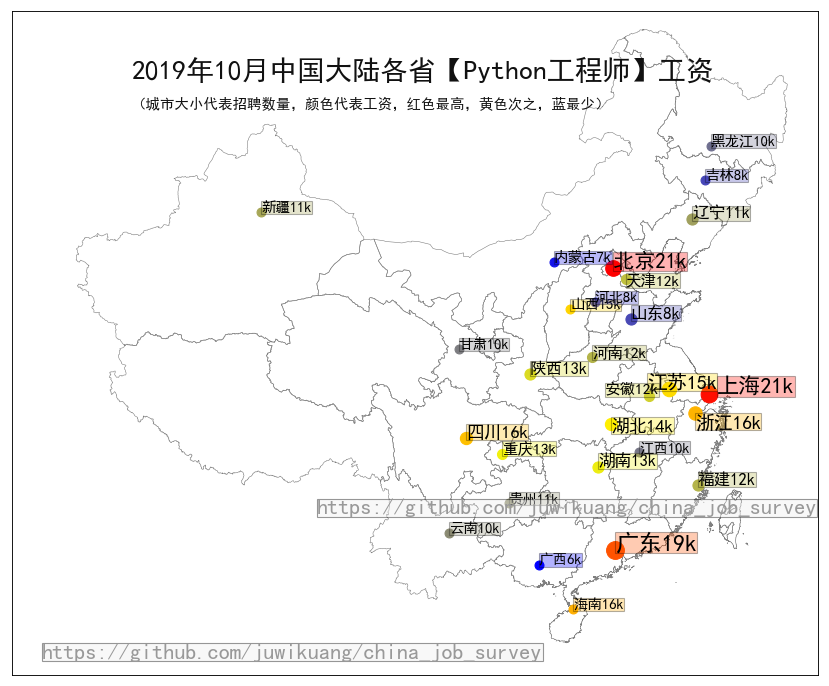

In [40]:
draw_map(data_python, 100,  f'2019年{month}月中国大陆各省【Python工程师】工资')